https://towardsdatascience.com/explaining-feature-importance-by-example-of-a-random-forest-d9166011959e

# Import

In [66]:
import os

from pprint import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from tqdm import tqdm
import pickle
import shap

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import recall_score, roc_auc_score, f1_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, learning_curve, GridSearchCV
from sklearn.dummy import DummyClassifier

from yellowbrick.datasets import load_game
from yellowbrick.model_selection import LearningCurve


In [67]:
def fit_and_predict(model, X_train, y_train, X_test):
    model.fit(X_train, y_train)
    return model.predict(X_test)

def f1_(y_test, predictions):
    return f1_score(y_test, predictions)

def recall_(y_test, predictions):
    return recall_score(y_test, predictions)

def auc_(y_test, predictions):
    return roc_auc_score(y_test, predictions)

# Load Data

In [68]:
os.chdir('./data/')

FileNotFoundError: [Errno 2] No such file or directory: './data/'

In [69]:
feature_cols = [
    'SK_ID_CURR',
    'EXT_SOURCE_1',
    'EXT_SOURCE_2',
    'EXT_SOURCE_3',
    'DAYS_BIRTH',
    'AMT_CREDIT',
    'AMT_ANNUITY',
    'DAYS_EMPLOYED',
    'AMT_GOODS_PRICE',
    'DAYS_ID_PUBLISH',
    'OWN_CAR_AGE',
    'BUREAU_MAX_DAYS_CREDIT',
    'BUREAU_MAX_DAYS_CREDIT_ENDDATE',
    'BUREAU_MAX_DAYS_ENDDATE_FACT',
    'PREV_SUM_MIN_AMT_PAYMENT',
    'PREV_MEAN_MIN_AMT_PAYMENT'
    ]

In [118]:
def load_data():
    data = {}
    for file in os.listdir():
        name = file.split('.')[0]
        data[name] = pd.read_csv(file, encoding='Latin-1')
    return data

def bureau(data, df, df_test):
    bureau_cols = ['DAYS_CREDIT', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT']
    bureau_cols_max = ['BUREAU_MAX_' + c for c in bureau_cols]
    key = 'SK_ID_CURR'
    data['bureau'][[key] + bureau_cols].groupby(key).max().rename(
          columns=dict(zip(bureau_cols, bureau_cols_max)))
    bureau_cols = ['DAYS_CREDIT', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT']

    bureau_cols_max = ['BUREAU_MAX_' + c for c in bureau_cols]

    df = pd.merge(
      left=df,
      right=data['bureau'][[key] + bureau_cols].groupby(key).max().rename(
          columns=dict(zip(bureau_cols, bureau_cols_max))),
      left_on=key,
      right_index=True, 
      how='left'
  )
    df_test = pd.merge(
      left=df_test,
      right=data['bureau'][[key] + bureau_cols].groupby(key).max().rename(
          columns=dict(zip(bureau_cols, bureau_cols_max))),
      left_on=key,
      right_index=True, 
      how='left'
  )
    return df, df_test


def previous_app_and_installements(data, df, df_test):
    key_prev = 'SK_ID_PREV'
    payment_cols = ['AMT_PAYMENT']

    # Min payment for all previous loans
    data['previous_application'] = pd.merge(
      left=data['previous_application'],
      right=data['installments_payments'][[key_prev] + payment_cols].groupby(key_prev).min(),
      left_on=key_prev,
      right_index=True,
      how='left'
  )
    key = 'SK_ID_CURR'
    prev_agg_cols = ['PREV_SUM_MIN_AMT_PAYMENT', 'PREV_MEAN_MIN_AMT_PAYMENT']

    # Sum and mean of minimum payments across all previous loans
    df_prev_agg = data['previous_application'][[key] + payment_cols].groupby(key).agg(['sum', 'mean']);
    df_prev_agg.columns = prev_agg_cols

    df = pd.merge(
      left=df,
      right=df_prev_agg,
      left_on=key,
      right_index=True,
      how='left'
  )

    df_test = pd.merge(
      left=df_test,
      right=df_prev_agg,
      left_on=key,
      right_index=True,
      how='left'
  )
    return df, df_test


def select_columns(df, df_test, feature_cols):
    return df[feature_cols], df_test[feature_cols], df['TARGET']


def main():
    data = load_data()
    df, df_test = data['application_train'], data['application_test']
    df, df_test = bureau(data, df, df_test)
    df, df_test = previous_app_and_installements(data, df, df_test)
    df, df_test, y = select_columns(df, df_test, feature_cols)

    df = df.fillna(value=df.mean())
    df_test = df_test.fillna(value=df.mean())

    df.SK_ID_CURR = df.SK_ID_CURR.astype(int)
    df_test.SK_ID_CURR = df_test.SK_ID_CURR.astype(int)
    return df, df_test, y

df, df_test, y = main()

In [119]:
X = df.drop(columns='SK_ID_CURR')

# Example: SK_ID_CURR #365597
X[df.SK_ID_CURR == 365597].transpose()

,229310
EXT_SOURCE_1,0.589340
EXT_SOURCE_2,0.507737
EXT_SOURCE_3,0.710674
DAYS_BIRTH,-10240.000000
AMT_CREDIT,152820.000000
AMT_ANNUITY,15241.500000
DAYS_EMPLOYED,-543.000000
AMT_GOODS_PRICE,135000.000000
DAYS_ID_PUBLISH,-355.000000
OWN_CAR_AGE,3.000000


In [120]:
df_test[df_test.SK_ID_CURR == 100001].transpose()

,0
SK_ID_CURR,100001.000000
EXT_SOURCE_1,0.752614
EXT_SOURCE_2,0.789654
EXT_SOURCE_3,0.159520
DAYS_BIRTH,-19241.000000
AMT_CREDIT,568800.000000
AMT_ANNUITY,20560.500000
DAYS_EMPLOYED,-2329.000000
AMT_GOODS_PRICE,450000.000000
DAYS_ID_PUBLISH,-812.000000


In [121]:
# creer un dataset avec toute la donnée
df['TARGET'] = y
df_test['TARGET'] = np.nan
df_complete = pd.concat([df_test, df],axis=0)
df_complete.to_csv('./df_complete.csv', index=False)

In [74]:
# creer un dataset avec la donnée de test (sans le target)
df_test.to_csv('../data_test.csv', index=False )

In [75]:
df_test.set_index('SK_ID_CURR', inplace=True, drop=True)

# Model du notebook

In [93]:
clf = RandomForestClassifier(
    n_estimators=50,
    criterion='gini',
    max_depth=5,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    #min_impurity_split=None,
    bootstrap=True,
    oob_score=False,
    n_jobs=-1,
    random_state=0,
    verbose=0,
    warm_start=False,
    class_weight='balanced'
)

In [97]:
def plot_roc_curve(fprs, tprs):
    """Plot the Receiver Operating Characteristic from a list
    of true positive rates and false positive rates."""
    
    # Initialize useful lists + the plot axes.
    tprs_interp = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(14,10))
    
    # Plot ROC for each K-Fold + compute AUC scores.
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    # Plot the luck line.
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)
    
    # Plot the mean ROC.
    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)
    # Plot the standard deviation around the mean ROC.
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')
    
    # Fine tune and show the plot.
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    ax.legend(loc="lower right")
    plt.show()
    return (f, ax)
def compute_roc_auc(index):
    y_predict = clf.predict_proba(X.iloc[index])[:,1]
    fpr, tpr, thresholds = roc_curve(y.iloc[index], y_predict)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score

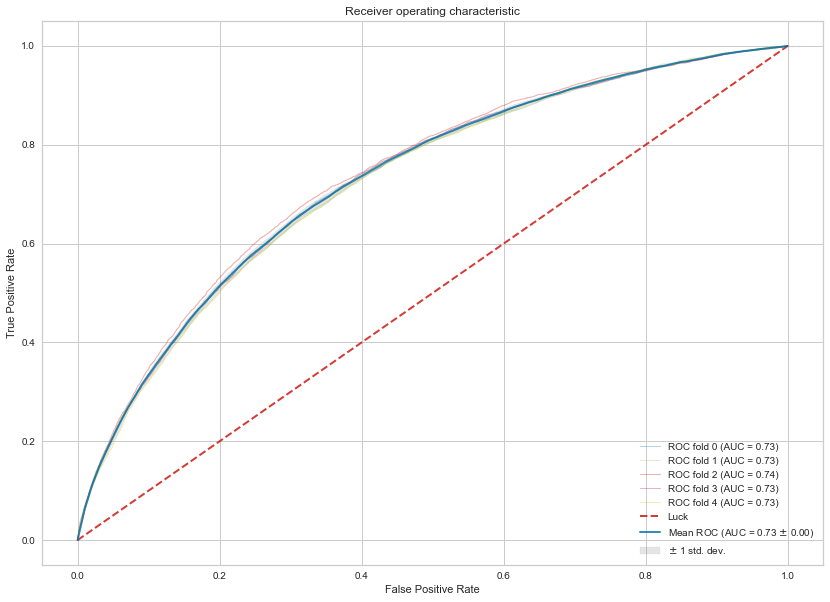

,AUC Train,AUC Test
0,0.736736,0.729911
1,0.737324,0.727502
2,0.734657,0.737889
3,0.737939,0.729900
4,0.737477,0.725004


In [98]:
cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []
    
for (train, test), i in zip(cv.split(X, y), range(5)):
    clf.fit(X.iloc[train], y.iloc[train])
    _, _, auc_score_train = compute_roc_auc(train)
    fpr, tpr, auc_score = compute_roc_auc(test)
    scores.append((auc_score_train, auc_score))
    fprs.append(fpr)
    tprs.append(tpr)

plot_roc_curve(fprs, tprs);
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])

# Entrainements 🦾

## Aucun prétraitement

Premiers modeles sans faire de prétraitement/finetuning \
Evaluation sur f1, recall et auc

### Baseline

In [42]:
dummy_clf = DummyClassifier(strategy="stratified")

dummy_clf.fit(X, y)

dummy_prediction = dummy_clf.predict(X_smote_moitie)
print('auc', auc_(y_smote_moitie, dummy_prediction))
print('f1', f1_(y_smote_moitie, dummy_prediction))
print('recall', recall_(y_smote_moitie, dummy_prediction))
#dummy_clf.score(X_smote_moitie, y_smote_moitie)

auc 0.49945522593973524
f1 0.12904988813171422
recall 0.08018791167585236


### EZEBARTI

In [84]:
skf = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)

models = {
    'logistic':LogisticRegression(class_weight='balanced', max_iter=1000),
    'randomforest':RandomForestClassifier(class_weight='balanced'),
    'knn' : KNeighborsClassifier()
}

In [23]:

#metrics = ['f1_', 'recall_', 'auc_']
res_model_simple={}

for model_name, model in models.items():
    print(f'{model_name} beggining .........')
    
    res_f1=[]
    res_recall=[]
    res_auc= []
    
    # je fais un split stratifié
    for train_ix, test_ix in skf.split(X, y):
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]
        predictions = fit_and_predict(model, X_train, y_train, X_test)
        res_f1.append(f1_(y_test, predictions))
        res_recall.append(recall_(y_test, predictions))
        res_auc.append(auc_(y_test, predictions))
    res_model_simple[model_name] = {'f1':np.mean(res_f1),
                                    'recall':np.mean(res_recall),
                                    'auc':np.mean(res_auc)
                     }
    print(f'{model_name} endding .........')

logistic beggining .........
logistic endding .........
randomforest beggining .........
randomforest endding .........
knn beggining .........


/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/base.

knn endding .........


In [29]:
pd.DataFrame(res_model_simple)

,logistic,randomforest,knn
f1,0.185744,0.014667,0.042287
recall,0.557140,0.007452,0.023807
auc,0.583516,0.503353,0.507437


## With scale data

In [25]:
# Baseline ne change pas

In [30]:
X_scaled = X.copy()
col_to_scale = X_scaled.columns

for col in col_to_scale:
    scaler = StandardScaler()
    X_scaled[col] = scaler.fit_transform(X_scaled[[col]])

In [31]:
skf = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)

res_scaled={}
for model_name, model in models.items():
    print(f'{model_name} beggining .........')
    
    res_f1=[]
    res_recall=[]
    res_auc= []
    
    # je fais un split stratifié
    for train_ix, test_ix in skf.split(X_scaled, y):
        X_train, X_test = X_scaled.iloc[train_ix], X_scaled.iloc[test_ix]
        y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]
        # je fit et predict sur le modele
        predictions = fit_and_predict(model, X_train, y_train, X_test)
        # je calcule mes métriques
        res_f1.append(f1_(y_test, predictions))
        res_recall.append(recall_(y_test, predictions))
        res_auc.append(auc_(y_test, predictions))
    # je conserve mes res
    res_scaled[model_name] = {
        'f1':np.mean(res_f1),
        'recall':np.mean(res_recall),
        'auc':np.mean(res_auc)
    }
    print(f'{model_name} endding .........')

logistic beggining .........
logistic endding .........
randomforest beggining .........
randomforest endding .........
knn beggining .........


/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/base.

knn endding .........


In [32]:
pd.DataFrame(res_scaled)

,logistic,randomforest,knn
f1,0.248094,0.014041,0.080166
recall,0.654864,0.007130,0.047855
auc,0.668285,0.503199,0.517519


## Smote

https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html

In [9]:
# transform the dataset
oversample = SMOTE(k_neighbors=15, sampling_strategy=0.5)
X_smote_moitie, y_smote_moitie = oversample.fit_resample(X, y)

## Logit

In [85]:
neighboors = [5, 10, 20, 30, 50, 100]
smote_ratios = [0.2, 0.4, 0.5, 1.]
skf = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)


def evaluate_best_smote_ratio(model_name, n_iter):
    scores = {}
    for i in tqdm(range(n_iter)):
        res_f1=[]
        res_recall=[]
        res_auc= []
        # selectionne au hasard des variables de smote et créer la donnée
        neighboor = np.random.choice(neighboors)
        smote_ratio = np.random.choice(smote_ratios)
        oversample = SMOTE(k_neighbors=neighboor, sampling_strategy=smote_ratio)
        

        
        # k fold la donnée smote
        for train_ix, test_ix in skf.split(X, y):
            X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
            y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]
            
            X_train, y_train = oversample.fit_resample(X_train, y_train)

            # je fit et predict sur le modele
            predictions = fit_and_predict(models[model_name],
                                          X_train,
                                          y_train,
                                          X_test)
            # je calcule mes métriques
            res_f1.append(f1_(y_test, predictions))
            res_recall.append(recall_(y_test, predictions))
            res_auc.append(auc_(y_test, predictions))

        scores[i]={
            'params':{'neighboor':neighboor,
                     'smote_ratio':smote_ratio},
            'f1':np.mean(res_f1),
            'recall':np.mean(res_recall),
            'auc':np.mean(res_auc)
        }
    return scores

In [86]:
model_to_test = ['logistic', 'randomforest']
res_smote = []
for model in model_to_test:
    res = evaluate_best_smote_ratio(model, 8)
    print(f'Pour le {model}, les valeurs sont les suivantes :')
    display(pd.DataFrame(res))
    res_smote.append(res)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [05:53<00:00, 44.19s/it]

Pour le logistic, les valeurs sont les suivantes :


,0,1,2,3,4,5,6,7
params,"{'neighboor': 50, 'smote_ratio': 0.4}","{'neighboor': 5, 'smote_ratio': 1.0}","{'neighboor': 50, 'smote_ratio': 0.5}","{'neighboor': 30, 'smote_ratio': 0.2}","{'neighboor': 50, 'smote_ratio': 0.2}","{'neighboor': 10, 'smote_ratio': 1.0}","{'neighboor': 20, 'smote_ratio': 1.0}","{'neighboor': 30, 'smote_ratio': 0.5}"
f1,0.185357,0.184748,0.185445,0.185551,0.185346,0.185535,0.185679,0.185599
recall,0.561853,0.558429,0.563142,0.560806,0.561772,0.561088,0.562941,0.562014
auc,0.583288,0.582187,0.58351,0.583497,0.583266,0.583491,0.583834,0.583648


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [1:00:32<00:00, 454.12s/it]

Pour le randomforest, les valeurs sont les suivantes :


,0,1,2,3,4,5,6,7
params,"{'neighboor': 50, 'smote_ratio': 1.0}","{'neighboor': 30, 'smote_ratio': 0.5}","{'neighboor': 10, 'smote_ratio': 0.2}","{'neighboor': 30, 'smote_ratio': 0.4}","{'neighboor': 5, 'smote_ratio': 0.2}","{'neighboor': 100, 'smote_ratio': 0.4}","{'neighboor': 100, 'smote_ratio': 0.5}","{'neighboor': 30, 'smote_ratio': 1.0}"
f1,0.209325,0.16588,0.069011,0.146368,0.067487,0.139318,0.162606,0.21185
recall,0.273515,0.144773,0.039758,0.113555,0.038912,0.106868,0.140141,0.278268
auc,0.577948,0.546018,0.51496,0.537565,0.514454,0.534691,0.544457,0.579929


Le modele le plus scalable semble être le random forest 🌴🌳🌲🎄

# randomforest 🌴🌳🌲🎄

## created data

In [87]:
# diminue le nombre d'entrées pour gridsearch car j'ai pas un pc de la nasa 🚀
X_ = X.copy()
X_['target'] = y
print(len(X_))
X_ = X_.sample(int(len(X_)/3))
print(len(X_))
y_ = X_['target']
X_.drop(columns=['target'], inplace=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42)
X_train_, X_test_, y_train_, y_test_ = train_test_split(
    X_, y_, test_size=0.30, random_state=42)


# transform the dataset with smote
oversample = SMOTE(k_neighbors=100, sampling_strategy=1)
X_smote_moitie_, y_smote_moitie_ = oversample.fit_resample(X_train_, y_train_)
X_smote_moitie, y_smote_moitie = oversample.fit_resample(X_train, y_train)

307511
102503


## Baseline

In [90]:
# baseline de la donnée smotée

dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_smote_moitie, y_smote_moitie)
DummyClassifier(strategy='most_frequent')
dummy_prediction = dummy_clf.predict(X_smote_moitie)
print('auc', auc_(y_smote_moitie, dummy_prediction))
print('f1', f1_(y_smote_moitie, dummy_prediction))
print('recall', recall_(y_smote_moitie, dummy_prediction))
#dummy_clf.score(X_smote_moitie, y_smote_moitie)

auc 0.5006242260355328
f1 0.5004171660017294
recall 0.5002097601657863


## Model non finetuné

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html

# optimiser le nombre de faux positif/faux negatif -> pondérer


In [277]:
%%time
# model de "base" non finetuné

rf = RandomForestClassifier(class_weight='balanced')

rf.fit(X_smote_moitie, y_smote_moitie)

predictions = rf.predict(X_test)

CPU times: user 2min 2s, sys: 1.28 s, total: 2min 3s
Wall time: 2min 6s


In [278]:
print('auc', auc_(y_test, predictions))
print('f1', f1_(y_test, predictions))
print('recall', recall_(y_test, predictions))

auc 0.5805856534234193
f1 0.21201305323271466
recall 0.2804532577903683


In [105]:
clf.fit(X_train, y_train)

predictions_model_notebook = clf.predict(X_test)

In [106]:
print('auc', auc_(y_test, predictions_model_notebook))
print('f1', f1_(y_test, predictions_model_notebook))
print('recall', recall_(y_test, predictions_model_notebook))

auc 0.6697199582832541
f1 0.24772756045068997
recall 0.6599217590719008


In [365]:
df_test_shap

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,AMT_CREDIT,AMT_ANNUITY,DAYS_EMPLOYED,AMT_GOODS_PRICE,DAYS_ID_PUBLISH,OWN_CAR_AGE,BUREAU_MAX_DAYS_CREDIT,BUREAU_MAX_DAYS_CREDIT_ENDDATE,BUREAU_MAX_DAYS_ENDDATE_FACT,PREV_SUM_MIN_AMT_PAYMENT,PREV_MEAN_MIN_AMT_PAYMENT
0,0.752614,0.789654,0.159520,-19241,568800.0,20560.5,-2329,450000.0,-812,12.061091,-49.000000,1778.000000,-544.000000,3951.000,3951.00000
1,0.564990,0.291656,0.432962,-18064,222768.0,17370.0,-4469,180000.0,-1623,12.061091,-62.000000,1324.000000,-123.000000,4813.200,4813.20000
2,0.502130,0.699787,0.610991,-20038,663264.0,69777.0,-4458,630000.0,-3503,5.000000,-1210.000000,-567.000000,-549.000000,6567.930,2189.31000
3,0.525734,0.509677,0.612704,-13976,1575000.0,49018.5,-1866,1575000.0,-4208,12.061091,-269.000000,30885.000000,-687.000000,12704.670,4234.89000
4,0.202145,0.425687,0.510853,-13040,625500.0,32067.0,-2191,625500.0,-4262,16.000000,-489.297817,4433.041953,-526.985948,11097.450,11097.45000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,0.502130,0.648575,0.643026,-19970,412560.0,17473.5,-5169,270000.0,-3399,12.061091,-113.000000,793.000000,-100.000000,14222.430,14222.43000
48740,0.502130,0.684596,0.510853,-11186,622413.0,31909.5,-1149,495000.0,-3003,12.061091,-489.297817,4433.041953,-526.985948,13978.305,3494.57625
48741,0.733503,0.632770,0.283712,-15922,315000.0,33205.5,-3037,315000.0,-1504,4.000000,-218.000000,-13.000000,-138.000000,28402.155,14201.07750
48742,0.373090,0.445701,0.595456,-13968,450000.0,25128.0,-2731,450000.0,-1364,12.061091,-515.000000,980.000000,-149.000000,28971.630,14485.81500


In [375]:
max(rf.predict_proba(df_test_shap)[0])

0.764115453990454

In [164]:
# save model
pickle.dump(rf, open('./random_orest_no_finetuning.pkl', 'wb'))

In [20]:
def get_features_importance(model,
                            features:list) -> pd.core.frame.DataFrame:
    '''get for each feature the importance for the model
    return it in DataFrame sorted deacreased'''
    importances = model.feature_importances_
    features_imp = pd.DataFrame(importances,
                                index=features,
                                columns=['feature_score']
                                )
    return features_imp.sort_values(by='feature_score',
                                    ascending=False)

def get_limit_values(features_imp, data, client_id):
    max_values = []
    min_values = []
    client_values = []
    for col in list(features_imp.index):
        max_values.append(data[col].max())
        min_values.append(data[col].min())
        client_values.append(data.loc[client_id, col])
    features_imp['max_value'] = max_values
    features_imp['min_value'] = min_values
    features_imp['client_value'] = client_values
    return features_imp

feature_imp = get_features_importance(rf, df_test.columns)
t = get_limit_values(feature_imp, df_test, 100001)

In [27]:
feature_imp.index

Index(['EXT_SOURCE_2', 'EXT_SOURCE_3', 'EXT_SOURCE_1',
       'BUREAU_MAX_DAYS_CREDIT_ENDDATE', 'DAYS_BIRTH', 'DAYS_ID_PUBLISH',
       'BUREAU_MAX_DAYS_ENDDATE_FACT', 'PREV_SUM_MIN_AMT_PAYMENT',
       'PREV_MEAN_MIN_AMT_PAYMENT', 'DAYS_EMPLOYED', 'BUREAU_MAX_DAYS_CREDIT',
       'AMT_ANNUITY', 'AMT_CREDIT', 'OWN_CAR_AGE', 'AMT_GOODS_PRICE'],
      dtype='object')

In [264]:
a = dict(zip(X_smote_moitie.columns, rf.feature_importances_))
{k: v for k, v in sorted(a.items(), key=lambda item: item[1], reverse=True)}

{'EXT_SOURCE_3': 0.13586360473033968,
 'EXT_SOURCE_2': 0.13039566834663896,
 'BUREAU_MAX_DAYS_CREDIT_ENDDATE': 0.0963469158748186,
 'EXT_SOURCE_1': 0.08248151476563842,
 'DAYS_BIRTH': 0.06832388646497854,
 'DAYS_ID_PUBLISH': 0.06439739819267085,
 'BUREAU_MAX_DAYS_ENDDATE_FACT': 0.06009720075370557,
 'PREV_MEAN_MIN_AMT_PAYMENT': 0.05155945077187245,
 'BUREAU_MAX_DAYS_CREDIT': 0.05141442623879161,
 'PREV_SUM_MIN_AMT_PAYMENT': 0.04938295223355926,
 'OWN_CAR_AGE': 0.0475668639354293,
 'DAYS_EMPLOYED': 0.04367834967256385,
 'AMT_ANNUITY': 0.042421904848773395,
 'AMT_CREDIT': 0.03954062951802182,
 'AMT_GOODS_PRICE': 0.03652923365219783}

<AxesSubplot:>

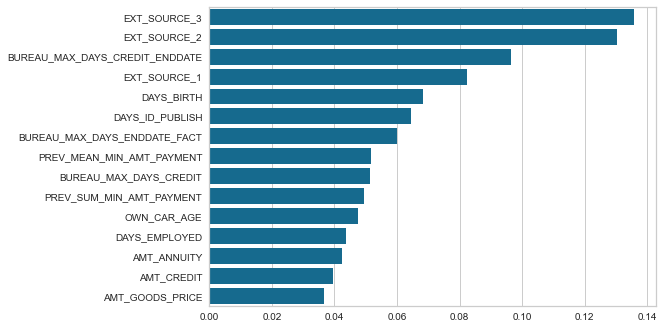

In [270]:
create_features_importance_model(rf, X_smote_moitie.columns)

In [269]:
def create_features_importance_model(model, columns):
    dict_f_i = dict(zip(columns, model.feature_importances_))
    dict_f_i = {k: v for k, v in sorted(dict_f_i.items(), key=lambda item: item[1], reverse=True)}
    return sns.barplot(x=list(dict_f_i.values()), y=list(dict_f_i.keys()), orient='h', color='b')
    

In [51]:
df_complete['EXT_SOURCE_1'].min()

0.0134579104986917

In [64]:
df_complete['a'] = df_complete['EXT_SOURCE_1'].apply(lambda x : np.float32(x))

In [80]:
a = pd.melt(df_complete)

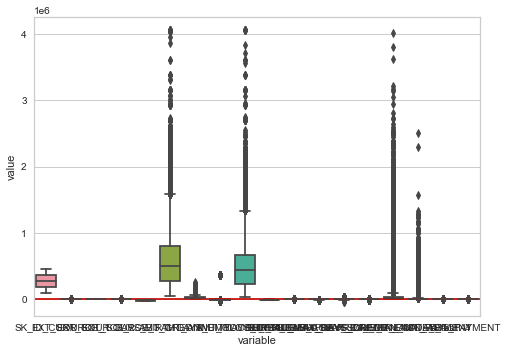

In [84]:
sns.boxplot(x='variable', y='value',data=a)


In [13]:
df_=df.copy()
df_['TARGET']=y

In [116]:
df_[df_.TARGET==0]['EXT_SOURCE_2']

1         0.622246
2         0.555912
3         0.650442
4         0.322738
5         0.354225
            ...   
307505    0.346391
307506    0.681632
307507    0.115992
307508    0.535722
307510    0.708569
Name: EXT_SOURCE_2, Length: 282686, dtype: float64

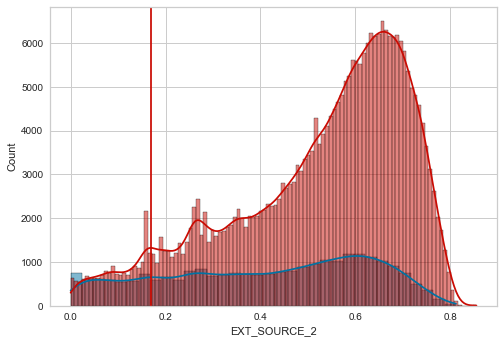

In [101]:
sns.histplot(df_[df_.TARGET==1]['EXT_SOURCE_2'], kde=True, color='b')
sns.histplot(df_[df_.TARGET==0]['EXT_SOURCE_2'], kde=True, color='r')
plt.axvline(0.17, color='r')

In [39]:
df_[['EXT_SOURCE_2', 'TARGET']]

,EXT_SOURCE_2,TARGET
0,0.262949,1
1,0.622246,0
2,0.555912,0
3,0.650442,0
4,0.322738,0
...,...,...
307506,0.681632,0
307507,0.115992,0
307508,0.535722,0
307509,0.514163,1


In [63]:
df.TARGET.isnull().sum()

128438

In [123]:
df_complete[~df_complete.TARGET.isna()]

,SK_ID_CURR,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,AMT_CREDIT,AMT_ANNUITY,DAYS_EMPLOYED,AMT_GOODS_PRICE,DAYS_ID_PUBLISH,OWN_CAR_AGE,BUREAU_MAX_DAYS_CREDIT,BUREAU_MAX_DAYS_CREDIT_ENDDATE,BUREAU_MAX_DAYS_ENDDATE_FACT,PREV_SUM_MIN_AMT_PAYMENT,PREV_MEAN_MIN_AMT_PAYMENT,TARGET
0,100002,0.083037,0.262949,0.139376,-9461,406597.5,24700.5,-637,351000.0,-2120,12.061091,-103.000000,780.000000,-36.000000,9251.775,9251.7750,1.0
1,100003,0.311267,0.622246,0.510853,-16765,1293502.5,35698.5,-1188,1129500.0,-291,12.061091,-606.000000,1216.000000,-540.000000,169295.580,56431.8600,0.0
2,100004,0.502130,0.555912,0.729567,-19046,135000.0,6750.0,-225,135000.0,-2531,26.000000,-408.000000,-382.000000,-382.000000,5357.250,5357.2500,0.0
3,100006,0.502130,0.650442,0.510853,-19005,312682.5,29686.5,-3039,297000.0,-2437,12.061091,-489.297817,4433.041953,-526.985948,723297.330,241099.1100,0.0
4,100007,0.502130,0.322738,0.510853,-19932,513000.0,21865.5,-3038,513000.0,-3458,12.061091,-1149.000000,-783.000000,-783.000000,33928.830,6785.7660,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0.145570,0.681632,0.510853,-9327,254700.0,27558.0,-236,225000.0,-1982,12.061091,-489.297817,4433.041953,-526.985948,6605.910,6605.9100,0.0
307507,456252,0.502130,0.115992,0.510853,-20775,269550.0,12001.5,365243,225000.0,-4090,12.061091,-489.297817,4433.041953,-526.985948,10046.880,10046.8800,0.0
307508,456253,0.744026,0.535722,0.218859,-14966,677664.0,29979.0,-7921,585000.0,-5150,12.061091,-713.000000,1113.000000,-794.000000,5594.985,2797.4925,0.0
307509,456254,0.502130,0.514163,0.661024,-11961,370107.0,20205.0,-4786,319500.0,-931,12.061091,-1104.000000,-859.000000,-859.000000,21362.265,10681.1325,1.0


In [45]:
df['TARGET']=y
df.drop(col=)

<AxesSubplot:xlabel='TARGET', ylabel='EXT_SOURCE_1'>

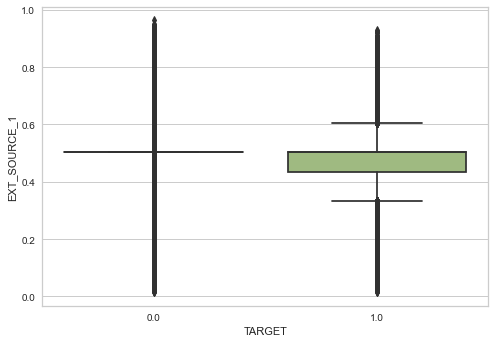

In [396]:
sns.boxplot(data=df_complete[~df_complete.TARGET.isna()], y='EXT_SOURCE_1', x='TARGET', orient="v")

<AxesSubplot:xlabel='TARGET', ylabel='EXT_SOURCE_1'>

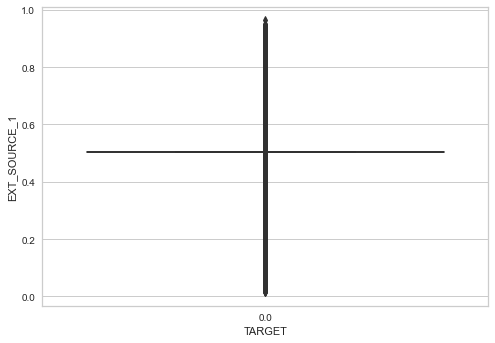

In [401]:
sns.boxplot(data=df_complete[df_complete.TARGET==0], y='EXT_SOURCE_1', x='TARGET', orient="v")

In [393]:
df_complete.loc[100010, 'EXT_SOURCE_1']

0.502129805656662

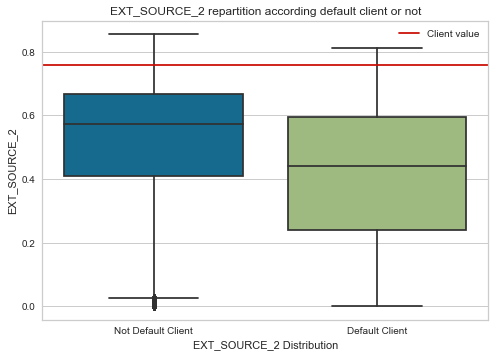

In [250]:
a = box_plot_client(df_complete, 'EXT_SOURCE_2', 100010)

In [126]:
#a = pd.melt(df_[['EXT_SOURCE_2', 'TARGET']])
#df_['TARGET'] = df_['TARGET'].map({1:'Default Client', 0:'Not Default Client'})
def x_tick_legend(old_legend):
    maping_legend = {'1.0': 'Default Client', '0.0': 'Not Default Client'}
    return maping_legend[old_legend]

def box_plot_client(data, feature, client_id):
    # create boxplot
    ax = sns.boxplot(data=data[~data.TARGET.isna()], y=feature, x='TARGET', orient="v")
    
    # add client treshshold
    ax.axhline(data.loc[client_id, feature],
               color='r',
               label='Client value')
    # add label and legend
    ax.legend()
    ax.set_xlabel(f'{feature} Distribution')
    labels = [item.get_text() for item in ax.get_xticklabels()]
    labels = [x_tick_legend(i) for i in labels]
    ax.set_xticklabels(labels)

    ax.set_title(f'{feature} repartition according default client or not')
    return ax


## Shap

In [150]:
df_test_shap = df_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'DAYS_BIRTH', 'AMT_CREDIT', 'AMT_ANNUITY', 'DAYS_EMPLOYED',
       'AMT_GOODS_PRICE', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'BUREAU_MAX_DAYS_CREDIT', 'BUREAU_MAX_DAYS_CREDIT_ENDDATE',
       'BUREAU_MAX_DAYS_ENDDATE_FACT', 'PREV_SUM_MIN_AMT_PAYMENT',
       'PREV_MEAN_MIN_AMT_PAYMENT']]

In [275]:
explainer = shap.Explainer(clf, X_train)

In [161]:
clf.predict_proba(choosen_instance)

array([[0.57932639, 0.42067361]])

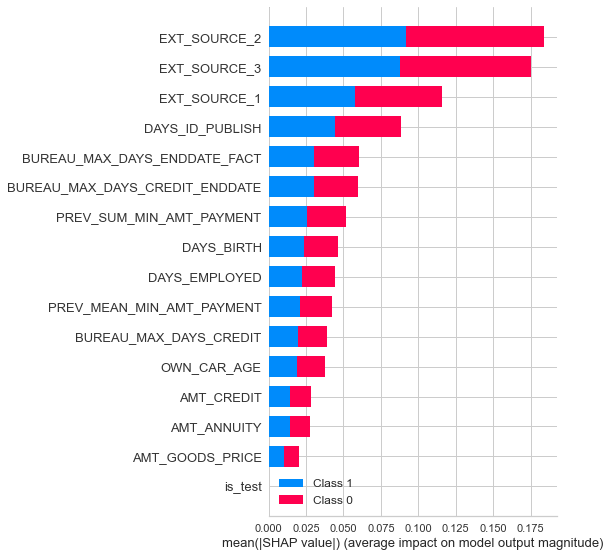

CPU times: user 2min 47s, sys: 922 ms, total: 2min 48s
Wall time: 2min 49s


In [25]:
%%time
t = df_test.sample(100)
shap_values_ = explainer.shap_values(t)
shap.summary_plot(shap_values_, t, plot_type="bar")

In [54]:
shap.summary_plot(shap_values, df_test[:10], plot_type='violon')

AssertionError: Only plot_type = 'bar' is supported for multi-output explanations!

In [162]:
explainer

In [ ]:
def make_plot(params_plot):
    f, ax = plt.subplots(1, 1, figsize=(15, 8))
    with plt.style.context('seaborn'):
        ax.scatter(params_plot[0], params_plot[1], label='before fitting')
        ax.plot(params_plot[2],
                params_plot[3],
                label='after fitting',
                color="orange")
        ax.set_xlabel('Time', fontsize=15)
        ax.set_ylabel(params_plot[4], fontsize=15)
        ax.legend(fontsize=15)
        return f

In [204]:
# Calculate Shap values
#choosen_instance = df_test_shap.sample(1)
def create_():
    fig = plt.figure()
    shap_values = explainer.shap_values(choosen_instance)
    #shap.initjs()
    fig = shap.force_plot(explainer.expected_value[0], shap_values[0], choosen_instance, matplotlib=True,show = False)
    return fig

In [298]:
for i in df_test_shap.columns:
    print(i)

EXT_SOURCE_1
EXT_SOURCE_2
EXT_SOURCE_3
DAYS_BIRTH
AMT_CREDIT
AMT_ANNUITY
DAYS_EMPLOYED
AMT_GOODS_PRICE
DAYS_ID_PUBLISH
OWN_CAR_AGE
BUREAU_MAX_DAYS_CREDIT
BUREAU_MAX_DAYS_CREDIT_ENDDATE
BUREAU_MAX_DAYS_ENDDATE_FACT
PREV_SUM_MIN_AMT_PAYMENT
PREV_MEAN_MIN_AMT_PAYMENT


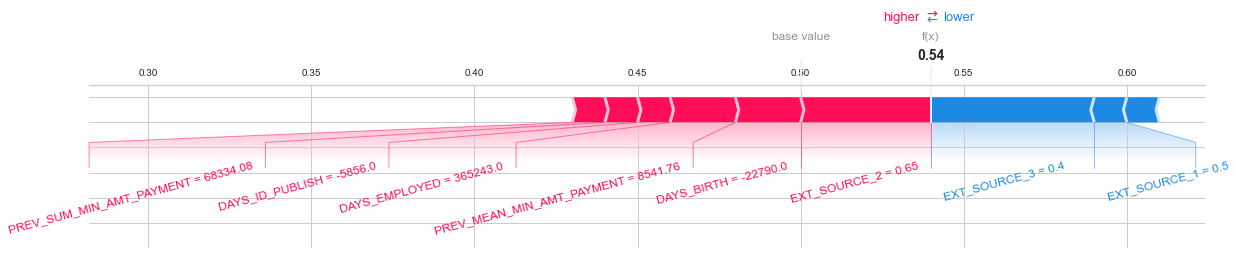

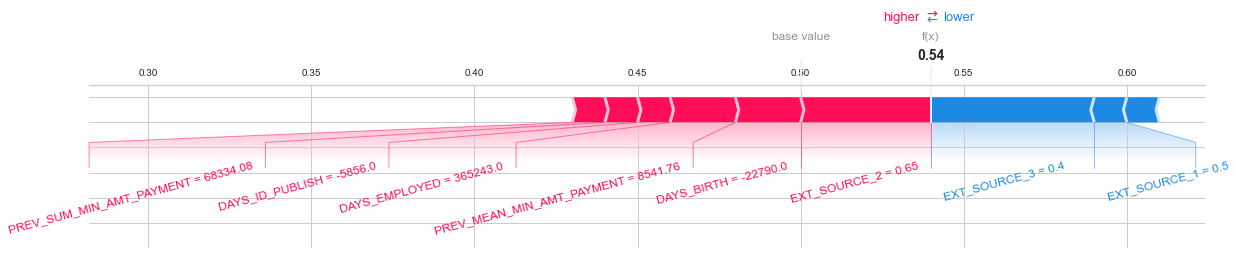

In [379]:
# Calculate Shap values
choosen_instance = df_test_shap.sample(1)

shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(np.around(explainer.expected_value[0], decimals=1),
                np.around(shap_values[0], decimals=2),
                np.around(choosen_instance, decimals=2),
                          matplotlib=True,show = False,
               text_rotation=15,)


In [244]:
df_complete[df_complete.index==69999].values

array([[ 1.81199000e+05,  5.02129806e-01,  4.29979734e-02,
         3.87625344e-01, -1.29590000e+04,  9.70380000e+05,
         3.43800000e+04, -2.64500000e+03,  8.10000000e+05,
        -4.08100000e+03,  1.20610908e+01, -9.00000000e+01,
         9.77400000e+03, -7.52000000e+02,  6.13755000e+02,
         3.06877500e+02,  1.00000000e+00]])

<Figure size 576x396 with 0 Axes>

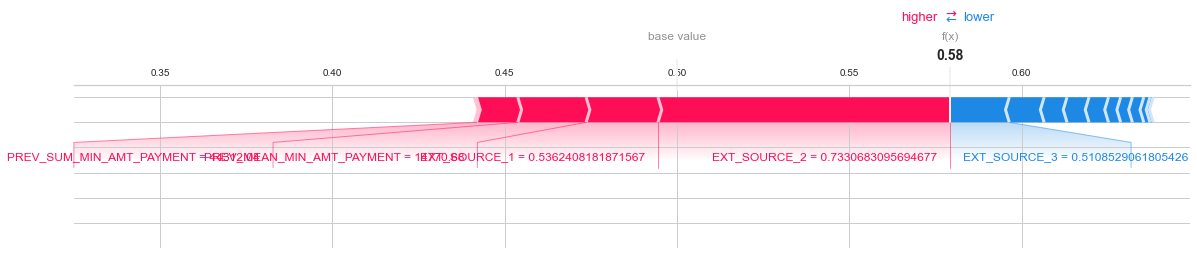

In [205]:
a = create_()

In [409]:
'''mean_value = 0.5
value=0.2
regime='test'
fig = go.Figure(go.Indicator(
                mode = "gauge+number+delta",
                value = value,
                domain = {'x': [0, 1], 'y': [0, 1]},
                title = {'text': regime},

                delta = {'reference': mean_value, 
                         'increasing': {'symbol': "😢", 'color':'#f94144'}, 
                         'decreasing': {'symbol': "😃", 'color':'#90be6d'}},
                gauge = {'axis': {'range': [0, 1],'tickwidth': 0.2,
                                 'tickvals':[0.2, 0.4, 0.6, 0.8, 1],
                                 'tickmode' : 'array',
                                 },
                         'bar': {'color': "#f5f3f4", 'line':{'width':2,'color':'black'},'thickness':0.8},
                        'steps': [
                        {'range': [0, 0.2], 'color': '#90be6d'},
                        {'range': [0.2, 0.4], 'color': '#f9c74f'},
                        {'range': [0.4, 0.6], 'color': '#f94144'},
                        {'range': [0.6, 1], 'color': 'blue'}
                        ]
                        }))
fig.show()'''

'mean_value = 0.5\nvalue=0.2\nregime=\'test\'\nfig = go.Figure(go.Indicator(\n                mode = "gauge+number+delta",\n                value = value,\n                domain = {\'x\': [0, 1], \'y\': [0, 1]},\n                title = {\'text\': regime},\n\n                delta = {\'reference\': mean_value, \n                         \'increasing\': {\'symbol\': "😢", \'color\':\'#f94144\'}, \n                         \'decreasing\': {\'symbol\': "😃", \'color\':\'#90be6d\'}},\n                gauge = {\'axis\': {\'range\': [0, 1],\'tickwidth\': 0.2,\n                                 \'tickvals\':[0.2, 0.4, 0.6, 0.8, 1],\n                                 \'tickmode\' : \'array\',\n                                 },\n                         \'bar\': {\'color\': "#f5f3f4", \'line\':{\'width\':2,\'color\':\'black\'},\'thickness\':0.8},\n                        \'steps\': [\n                        {\'range\': [0, 0.2], \'color\': \'#90be6d\'},\n                        {\'range\': [0.2

In [362]:
max([1,2])

2

In [376]:
def create_gauge_plot(probabilitie):
    plot_bgcolor = "#fff"
    quadrant_colors = [plot_bgcolor, "#2bad4e", "#85e043",  "#eff229", "#f2a529", "#f25829"] 
    quadrant_text = ["", "<b>Very high</b>", "<b>High</b>", "<b>Medium</b>", "<b>Low</b>", "<b>Very low</b>"]
    n_quadrants = len(quadrant_colors) - 1
    
    current_value = (probabilitie-0.5)
    min_value = 0
    max_value = 0.5
    hand_length = np.sqrt(2) / 4
    hand_angle = np.pi * (1 - (max(min_value, min(max_value, current_value)) - min_value) / (max_value - min_value))

    fig = go.Figure(
        data=[
            go.Pie(
                values=[0.5] + (np.ones(n_quadrants) / 2 / n_quadrants).tolist(),
                rotation=90,
                hole=0.5,
                marker_colors=quadrant_colors,
                text=quadrant_text,
                textinfo="text",
                hoverinfo="skip",
            ),
        ],
        layout=go.Layout(
            showlegend=False,
            margin=dict(b=0,t=10,l=10,r=10),
            width=450,
            height=450,
            paper_bgcolor=plot_bgcolor,
            annotations=[
                go.layout.Annotation(
                    text=f"<b>Probability that client is well classified :</b><br>{probabilitie}",
                    x=0.5, xanchor="center", xref="paper",
                    y=0.25, yanchor="bottom", yref="paper",
                    showarrow=False,
                )
            ],
            shapes=[
                go.layout.Shape(
                    type="circle",
                    x0=0.48, x1=0.52,
                    y0=0.48, y1=0.52,
                    fillcolor="#333",
                    line_color="#333",
                ),
                go.layout.Shape(
                    type="line",
                    x0=0.5, x1=0.5 + hand_length * np.cos(hand_angle),
                    y0=0.5, y1=0.5 + hand_length * np.sin(hand_angle),
                    line=dict(color="#333", width=4)
                )
            ]
        )
    )
    fig.show()
    
create_gauge_plot(0.65)

0.1

In [276]:
%%time
shap_values_ = explainer(X_train)

100%|===================| 430275/430514 [10:40<00:00]        

ExplainerError: Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. This check failed because for one of the samples the sum of the SHAP values was 0.368836, while the model output was 0.359859. If this difference is acceptable you can set check_additivity=False to disable this check.

In [232]:
shap.plots.waterfall(shap_values_[0])

Exception: waterfall_plot requires a scalar base_values of the model output as the first parameter, but you have passed an array as the first parameter! Try shap.waterfall_plot(explainer.base_values[0], values[0], X[0]) or for multi-output models try shap.waterfall_plot(explainer.base_values[0], values[0][0], X[0]).

In [207]:
type(a)

matplotlib.figure.Figure

In [63]:
vals

array([[0.04048133, 0.07325375, 0.08407035, 0.03407517, 0.02298225,
        0.01941921, 0.02350844, 0.00445473, 0.02590156, 0.01348777,
        0.00900183, 0.01817179, 0.0117626 , 0.01109555, 0.01172628,
        0.        ]])

In [66]:
df_test.drop(columns='is_test', inplace=True)

In [79]:
len(list(vals[0]))

16

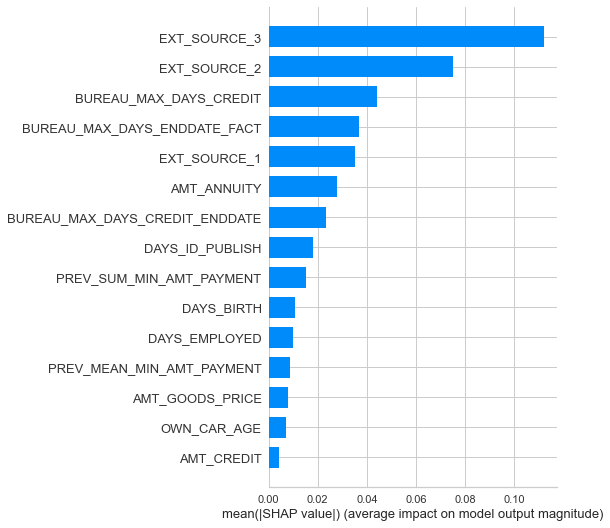

In [107]:
shap.summary_plot(shap_values[1], choosen_instance, plot_type="bar")

In [154]:
vals = np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(df_test_shap.columns, sum(vals))), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance

,col_name,feature_importance_vals
2,EXT_SOURCE_3,0.113392
1,EXT_SOURCE_2,0.068708
3,DAYS_BIRTH,0.023577
14,PREV_MEAN_MIN_AMT_PAYMENT,0.019236
13,PREV_SUM_MIN_AMT_PAYMENT,0.009716
6,DAYS_EMPLOYED,0.009556
0,EXT_SOURCE_1,0.006542
8,DAYS_ID_PUBLISH,0.005678
7,AMT_GOODS_PRICE,0.004533
11,BUREAU_MAX_DAYS_CREDIT_ENDDATE,0.002917


In [165]:
df__.drop(columns=['SK_ID_CURR'], inplace=True)

In [162]:
df__ = df.drop(columns=['is_test', 'TARGET'])

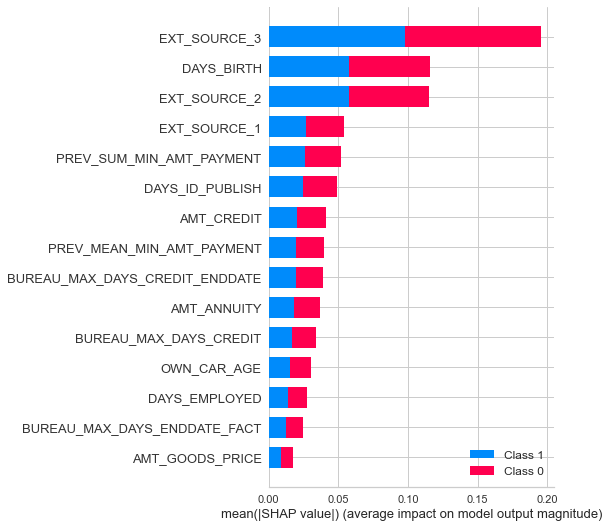

In [69]:
shap.summary_plot(shap_values_, df)

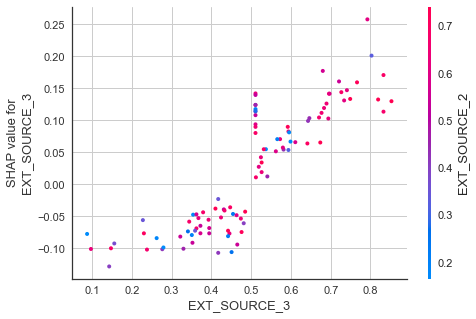

In [113]:
shap.dependence_plot("EXT_SOURCE_3", shap_values_[0], t)

## learning curves

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


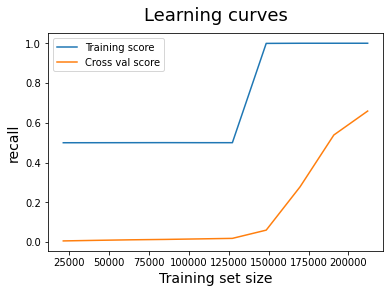

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/maximedupouy/.p

In [70]:
#train_sizes = [i for i in range(100, int(len(X)*0.1), 2000)]
train_sizes = np.linspace(0.1,1,10)
rf = RandomForestClassifier(class_weight='balanced')
learning_curves(rf, X_smote_moitie, y_smote_moitie, train_sizes, cv=2, scoring='recall')

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


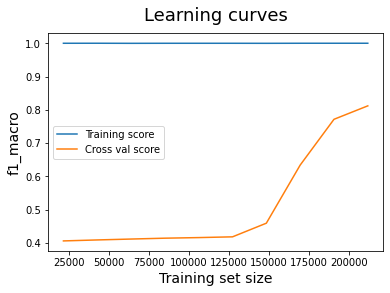

In [69]:
rf = RandomForestClassifier(class_weight='balanced')
learning_curves(rf, X_smote_moitie, y_smote_moitie, train_sizes, cv=2, scoring='f1_macro')

## Gridsearch

In [138]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 400, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [10, 30, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 4, 10, 20]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               }
#'bootstrap': bootstrap
# 'max_features': max_features,
pprint(param_grid)

{'max_depth': [10, 53, 96, 140, 183, 226, 270, 313, 356, 400, None],
 'min_samples_leaf': [1, 4, 10, 20],
 'min_samples_split': [10, 30, 100],
 'n_estimators': [10, 32, 55, 77, 100]}


In [223]:
# Create a based model
rf = RandomForestClassifier(class_weight='balanced')
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid= param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, scoring='roc_auc')
grid_search.fit(X_smote_moitie_, y_smote_moitie_)

Fitting 3 folds for each of 660 candidates, totalling 1980 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=10; total time=   2.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=77; total time=  14.8s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=30, n_estimators=32; total time=   6.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=30, n_estimators=77; total time=  14.9s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=100, n_estimators=55; total time=  10.5s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=100, n_estimators=100; total time=  18.7s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=  19.5s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=30, n_estimators=77; total time=  14.8s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=100, n_estimators=77; total time=  14.7s
[CV] END max_depth=10,

[CV] END max_depth=140, min_samples_leaf=10, min_samples_split=100, n_estimators=10; total time=   2.5s[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=32; total time=   6.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=  19.7s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=30, n_estimators=100; total time=  19.6s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=100, n_estimators=77; total time=  14.5s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=55; total time=  10.5s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=30, n_estimators=10; total time=   2.0s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=30, n_estimators=32; total time=   6.3s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=30, n_estimators=55; total time=  10.6s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=100, n_estimators=10; tot

[CV] END max_depth=96, min_samples_leaf=10, min_samples_split=100, n_estimators=55; total time=  13.8s[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=32; total time=   6.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=77; total time=  14.8s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=30, n_estimators=77; total time=  15.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=100, n_estimators=32; total time=   6.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=100, n_estimators=77; total time=  14.5s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=55; total time=  10.8s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=  19.5s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=30, n_estimators=100; total time=  19.6s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=100, n_estimators=77; tot

[CV] END max_depth=140, min_samples_leaf=4, min_samples_split=100, n_estimators=55; total time=  15.3s[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=55; total time=  10.8s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=30, n_estimators=10; total time=   1.9s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=30, n_estimators=10; total time=   1.9s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=30, n_estimators=32; total time=   6.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=30, n_estimators=55; total time=  10.7s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=100, n_estimators=10; total time=   2.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=100, n_estimators=10; total time=   1.9s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=100, n_estimators=32; total time=   6.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=100, n_estimators=77; tota

[CV] END max_depth=140, min_samples_leaf=1, min_samples_split=30, n_estimators=10; total time=   3.2s[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=10; total time=   2.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=55; total time=  10.6s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=30, n_estimators=10; total time=   2.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=30, n_estimators=32; total time=   6.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=30, n_estimators=55; total time=  10.8s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=100, n_estimators=10; total time=   2.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=100, n_estimators=32; total time=   6.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=100, n_estimators=55; total time=  10.5s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=10; total 

[CV] END max_depth=140, min_samples_leaf=10, min_samples_split=100, n_estimators=55; total time=  14.3s[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=32; total time=   6.4s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=  18.8s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=30, n_estimators=77; total time=  15.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=100, n_estimators=55; total time=  10.3s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=10; total time=   1.9s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=32; total time=   6.2s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=55; total time=  10.6s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=30, n_estimators=10; total time=   2.0s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=30, n_estimators=10; total

[CV] END max_depth=140, min_samples_leaf=1, min_samples_split=10, n_estimators=77; total time=  24.2s[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=55; total time=  10.6s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=  19.4s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=30, n_estimators=100; total time=  19.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=100, n_estimators=100; total time=  18.9s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=  19.4s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=30, n_estimators=100; total time=  19.3s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=100, n_estimators=100; total time=  19.0s
[CV] END max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=77; total time=  14.7s
[CV] END max_depth=10, min_samples_leaf=10, min_samples_split=30, n_estimators=77;

[CV] END max_depth=183, min_samples_leaf=4, min_samples_split=10, n_estimators=10; total time=   3.1s[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=10; total time=   2.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=77; total time=  15.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=30, n_estimators=55; total time=  10.8s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=30, n_estimators=100; total time=  19.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=100, n_estimators=100; total time=  19.2s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=77; total time=  15.0s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=30, n_estimators=77; total time=  15.1s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=100, n_estimators=32; total time=   6.1s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=100, n_estimators=77; tota

[CV] END max_depth=183, min_samples_leaf=20, min_samples_split=30, n_estimators=10; total time=   2.6s
[CV] END max_depth=140, min_samples_leaf=1, min_samples_split=30, n_estimators=10; total time=   3.0s
[CV] END max_depth=140, min_samples_leaf=1, min_samples_split=30, n_estimators=32; total time=   9.7s
[CV] END max_depth=140, min_samples_leaf=1, min_samples_split=30, n_estimators=55; total time=  17.0s
[CV] END max_depth=140, min_samples_leaf=1, min_samples_split=100, n_estimators=10; total time=   2.8s
[CV] END max_depth=140, min_samples_leaf=1, min_samples_split=100, n_estimators=32; total time=   9.1s
[CV] END max_depth=140, min_samples_leaf=1, min_samples_split=100, n_estimators=55; total time=  15.0s
[CV] END max_depth=140, min_samples_leaf=1, min_samples_split=100, n_estimators=100; total time=  28.2s
[CV] END max_depth=140, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=  30.0s
[CV] END max_depth=140, min_samples_leaf=4, min_samples_split=30, n_estimat

[CV] END max_depth=270, min_samples_leaf=20, min_samples_split=30, n_estimators=32; total time=   8.1s
[CV] END max_depth=96, min_samples_leaf=20, min_samples_split=10, n_estimators=10; total time=   2.6s
[CV] END max_depth=96, min_samples_leaf=20, min_samples_split=10, n_estimators=32; total time=   8.4s
[CV] END max_depth=96, min_samples_leaf=20, min_samples_split=10, n_estimators=55; total time=  14.6s
[CV] END max_depth=96, min_samples_leaf=20, min_samples_split=30, n_estimators=10; total time=   2.7s
[CV] END max_depth=96, min_samples_leaf=20, min_samples_split=30, n_estimators=10; total time=   2.5s
[CV] END max_depth=96, min_samples_leaf=20, min_samples_split=30, n_estimators=32; total time=   8.2s
[CV] END max_depth=96, min_samples_leaf=20, min_samples_split=30, n_estimators=55; total time=  14.1s
[CV] END max_depth=96, min_samples_leaf=20, min_samples_split=100, n_estimators=10; total time=   2.5s
[CV] END max_depth=96, min_samples_leaf=20, min_samples_split=100, n_estimators=

[CV] END max_depth=270, min_samples_leaf=4, min_samples_split=100, n_estimators=77; total time=  20.2s
[CV] END max_depth=140, min_samples_leaf=20, min_samples_split=10, n_estimators=10; total time=   2.6s
[CV] END max_depth=140, min_samples_leaf=20, min_samples_split=10, n_estimators=32; total time=   8.4s
[CV] END max_depth=140, min_samples_leaf=20, min_samples_split=10, n_estimators=55; total time=  14.6s
[CV] END max_depth=140, min_samples_leaf=20, min_samples_split=30, n_estimators=10; total time=   2.8s
[CV] END max_depth=140, min_samples_leaf=20, min_samples_split=30, n_estimators=10; total time=   2.7s
[CV] END max_depth=140, min_samples_leaf=20, min_samples_split=30, n_estimators=32; total time=   8.6s
[CV] END max_depth=140, min_samples_leaf=20, min_samples_split=30, n_estimators=55; total time=  14.6s
[CV] END max_depth=140, min_samples_leaf=20, min_samples_split=100, n_estimators=10; total time=   2.5s
[CV] END max_depth=140, min_samples_leaf=20, min_samples_split=100, n_es

[CV] END max_depth=313, min_samples_leaf=1, min_samples_split=10, n_estimators=55; total time=  17.2s
[CV] END max_depth=140, min_samples_leaf=1, min_samples_split=30, n_estimators=77; total time=  24.2s
[CV] END max_depth=140, min_samples_leaf=1, min_samples_split=100, n_estimators=32; total time=   8.6s
[CV] END max_depth=140, min_samples_leaf=1, min_samples_split=100, n_estimators=77; total time=  20.8s
[CV] END max_depth=140, min_samples_leaf=4, min_samples_split=10, n_estimators=32; total time=   9.5s
[CV] END max_depth=140, min_samples_leaf=4, min_samples_split=10, n_estimators=77; total time=  23.5s
[CV] END max_depth=140, min_samples_leaf=4, min_samples_split=30, n_estimators=55; total time=  16.3s
[CV] END max_depth=140, min_samples_leaf=4, min_samples_split=30, n_estimators=100; total time=  28.9s
[CV] END max_depth=140, min_samples_leaf=4, min_samples_split=100, n_estimators=100; total time=  26.3s
[CV] END max_depth=140, min_samples_leaf=10, min_samples_split=10, n_estimato

[CV] END max_depth=313, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=  31.8s
[CV] END max_depth=140, min_samples_leaf=10, min_samples_split=100, n_estimators=32; total time=   8.0s
[CV] END max_depth=140, min_samples_leaf=10, min_samples_split=100, n_estimators=55; total time=  13.9s
[CV] END max_depth=140, min_samples_leaf=20, min_samples_split=10, n_estimators=10; total time=   2.7s
[CV] END max_depth=140, min_samples_leaf=20, min_samples_split=10, n_estimators=10; total time=   2.6s
[CV] END max_depth=140, min_samples_leaf=20, min_samples_split=10, n_estimators=32; total time=   8.2s
[CV] END max_depth=140, min_samples_leaf=20, min_samples_split=10, n_estimators=55; total time=  13.9s
[CV] END max_depth=140, min_samples_leaf=20, min_samples_split=30, n_estimators=10; total time=   2.7s
[CV] END max_depth=140, min_samples_leaf=20, min_samples_split=30, n_estimators=32; total time=   8.8s
[CV] END max_depth=140, min_samples_leaf=20, min_samples_split=30, n_es

[CV] END max_depth=270, min_samples_leaf=1, min_samples_split=100, n_estimators=100; total time=  28.3s
[CV] END max_depth=140, min_samples_leaf=4, min_samples_split=100, n_estimators=100; total time=  26.7s
[CV] END max_depth=140, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=  29.1s
[CV] END max_depth=140, min_samples_leaf=10, min_samples_split=30, n_estimators=100; total time=  27.4s
[CV] END max_depth=140, min_samples_leaf=10, min_samples_split=100, n_estimators=100; total time=  26.3s
[CV] END max_depth=140, min_samples_leaf=20, min_samples_split=10, n_estimators=100; total time=  27.4s
[CV] END max_depth=140, min_samples_leaf=20, min_samples_split=30, n_estimators=100; total time=  26.3s
[CV] END max_depth=140, min_samples_leaf=20, min_samples_split=100, n_estimators=100; total time=  25.9s
[CV] END max_depth=183, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=  32.6s
[CV] END max_depth=183, min_samples_leaf=1, min_samples_split=3

GridSearchCV(cv=3, estimator=RandomForestClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'max_depth': [10, 53, 96, 140, 183, 226, 270, 313, 356,
                                       400, None],
                         'min_samples_leaf': [1, 4, 10, 20],
                         'min_samples_split': [10, 30, 100],
                         'n_estimators': [10, 32, 55, 77, 100]},
             scoring='roc_auc', verbose=2)


[CV] END max_depth=270, min_samples_leaf=10, min_samples_split=10, n_estimators=55; total time=  15.6s
[CV] END max_depth=270, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=  27.3s
[CV] END max_depth=270, min_samples_leaf=10, min_samples_split=30, n_estimators=100; total time=  27.9s
[CV] END max_depth=270, min_samples_leaf=10, min_samples_split=100, n_estimators=100; total time=  26.3s
[CV] END max_depth=270, min_samples_leaf=20, min_samples_split=10, n_estimators=100; total time=  25.3s
[CV] END max_depth=270, min_samples_leaf=20, min_samples_split=30, n_estimators=77; total time=  19.1s
[CV] END max_depth=270, min_samples_leaf=20, min_samples_split=100, n_estimators=77; total time=  18.9s
[CV] END max_depth=313, min_samples_leaf=1, min_samples_split=10, n_estimators=32; total time=  10.2s
[CV] END max_depth=313, min_samples_leaf=1, min_samples_split=10, n_estimators=77; total time=  23.8s
[CV] END max_depth=313, min_samples_leaf=1, min_samples_split=30, n_


[CV] END max_depth=183, min_samples_leaf=20, min_samples_split=30, n_estimators=32; total time=   8.5s
[CV] END max_depth=183, min_samples_leaf=20, min_samples_split=30, n_estimators=32; total time=   8.4s
[CV] END max_depth=183, min_samples_leaf=20, min_samples_split=30, n_estimators=77; total time=  20.0s
[CV] END max_depth=183, min_samples_leaf=20, min_samples_split=100, n_estimators=55; total time=  13.4s
[CV] END max_depth=226, min_samples_leaf=1, min_samples_split=10, n_estimators=10; total time=   3.3s
[CV] END max_depth=226, min_samples_leaf=1, min_samples_split=10, n_estimators=10; total time=   3.1s
[CV] END max_depth=226, min_samples_leaf=1, min_samples_split=10, n_estimators=32; total time=  10.0s
[CV] END max_depth=226, min_samples_leaf=1, min_samples_split=10, n_estimators=77; total time=  25.5s
[CV] END max_depth=226, min_samples_leaf=1, min_samples_split=30, n_estimators=32; total time=   9.7s
[CV] END max_depth=226, min_samples_leaf=1, min_samples_split=30, n_estimato


[CV] END max_depth=270, min_samples_leaf=10, min_samples_split=100, n_estimators=10; total time=   2.8s
[CV] END max_depth=270, min_samples_leaf=10, min_samples_split=100, n_estimators=10; total time=   2.6s
[CV] END max_depth=270, min_samples_leaf=10, min_samples_split=100, n_estimators=32; total time=   8.2s
[CV] END max_depth=270, min_samples_leaf=10, min_samples_split=100, n_estimators=55; total time=  13.9s
[CV] END max_depth=270, min_samples_leaf=20, min_samples_split=10, n_estimators=10; total time=   2.6s
[CV] END max_depth=270, min_samples_leaf=20, min_samples_split=10, n_estimators=32; total time=   8.4s
[CV] END max_depth=270, min_samples_leaf=20, min_samples_split=10, n_estimators=55; total time=  14.3s
[CV] END max_depth=270, min_samples_leaf=20, min_samples_split=10, n_estimators=100; total time=  25.2s
[CV] END max_depth=270, min_samples_leaf=20, min_samples_split=30, n_estimators=100; total time=  26.1s
[CV] END max_depth=270, min_samples_leaf=20, min_samples_split=100


[CV] END max_depth=270, min_samples_leaf=20, min_samples_split=30, n_estimators=77; total time=  19.3s
[CV] END max_depth=270, min_samples_leaf=20, min_samples_split=100, n_estimators=55; total time=  13.2s
[CV] END max_depth=313, min_samples_leaf=1, min_samples_split=10, n_estimators=10; total time=   3.1s
[CV] END max_depth=313, min_samples_leaf=1, min_samples_split=10, n_estimators=32; total time=  10.4s
[CV] END max_depth=313, min_samples_leaf=1, min_samples_split=10, n_estimators=55; total time=  17.0s
[CV] END max_depth=313, min_samples_leaf=1, min_samples_split=30, n_estimators=10; total time=   3.1s
[CV] END max_depth=313, min_samples_leaf=1, min_samples_split=30, n_estimators=10; total time=   2.9s
[CV] END max_depth=313, min_samples_leaf=1, min_samples_split=30, n_estimators=32; total time=   9.5s
[CV] END max_depth=313, min_samples_leaf=1, min_samples_split=30, n_estimators=55; total time=  16.1s
[CV] END max_depth=313, min_samples_leaf=1, min_samples_split=100, n_estimator


[CV] END max_depth=313, min_samples_leaf=1, min_samples_split=30, n_estimators=77; total time=  23.3s
[CV] END max_depth=313, min_samples_leaf=1, min_samples_split=100, n_estimators=77; total time=  21.3s
[CV] END max_depth=313, min_samples_leaf=4, min_samples_split=10, n_estimators=32; total time=   9.4s
[CV] END max_depth=313, min_samples_leaf=4, min_samples_split=10, n_estimators=77; total time=  23.0s
[CV] END max_depth=313, min_samples_leaf=4, min_samples_split=30, n_estimators=55; total time=  16.2s
[CV] END max_depth=313, min_samples_leaf=4, min_samples_split=30, n_estimators=100; total time=  28.2s
[CV] END max_depth=313, min_samples_leaf=4, min_samples_split=100, n_estimators=100; total time=  27.6s
[CV] END max_depth=313, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=  27.4s
[CV] END max_depth=313, min_samples_leaf=10, min_samples_split=30, n_estimators=77; total time=  20.9s
[CV] END max_depth=313, min_samples_leaf=10, min_samples_split=100, n_esti


[CV] END max_depth=270, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=  30.5s
[CV] END max_depth=270, min_samples_leaf=4, min_samples_split=30, n_estimators=100; total time=  28.5s
[CV] END max_depth=270, min_samples_leaf=4, min_samples_split=100, n_estimators=77; total time=  20.1s
[CV] END max_depth=270, min_samples_leaf=10, min_samples_split=10, n_estimators=77; total time=  21.7s
[CV] END max_depth=270, min_samples_leaf=10, min_samples_split=30, n_estimators=32; total time=   8.6s
[CV] END max_depth=270, min_samples_leaf=10, min_samples_split=30, n_estimators=77; total time=  21.7s
[CV] END max_depth=270, min_samples_leaf=10, min_samples_split=100, n_estimators=55; total time=  14.4s
[CV] END max_depth=270, min_samples_leaf=10, min_samples_split=100, n_estimators=100; total time=  25.1s
[CV] END max_depth=270, min_samples_leaf=20, min_samples_split=10, n_estimators=77; total time=  19.3s
[CV] END max_depth=270, min_samples_leaf=20, min_samples_split=30, n_


[CV] END max_depth=313, min_samples_leaf=1, min_samples_split=30, n_estimators=10; total time=   3.0s
[CV] END max_depth=313, min_samples_leaf=1, min_samples_split=30, n_estimators=32; total time=   9.7s
[CV] END max_depth=313, min_samples_leaf=1, min_samples_split=30, n_estimators=77; total time=  23.8s
[CV] END max_depth=313, min_samples_leaf=1, min_samples_split=100, n_estimators=32; total time=   8.9s
[CV] END max_depth=313, min_samples_leaf=1, min_samples_split=100, n_estimators=77; total time=  20.4s
[CV] END max_depth=313, min_samples_leaf=4, min_samples_split=10, n_estimators=55; total time=  16.7s
[CV] END max_depth=313, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=  31.1s
[CV] END max_depth=313, min_samples_leaf=4, min_samples_split=30, n_estimators=100; total time=  28.6s
[CV] END max_depth=313, min_samples_leaf=4, min_samples_split=100, n_estimators=77; total time=  20.7s
[CV] END max_depth=313, min_samples_leaf=10, min_samples_split=10, n_estimat

[CV] END max_depth=313, min_samples_leaf=20, min_samples_split=10, n_estimators=55; total time=  14.9s
[CV] END max_depth=313, min_samples_leaf=20, min_samples_split=10, n_estimators=100; total time=  25.5s
[CV] END max_depth=313, min_samples_leaf=20, min_samples_split=30, n_estimators=100; total time=  26.8s
[CV] END max_depth=313, min_samples_leaf=20, min_samples_split=100, n_estimators=100; total time=  24.3s
[CV] END max_depth=356, min_samples_leaf=1, min_samples_split=10, n_estimators=77; total time=  25.0s
[CV] END max_depth=356, min_samples_leaf=1, min_samples_split=30, n_estimators=55; total time=  16.5s
[CV] END max_depth=356, min_samples_leaf=1, min_samples_split=100, n_estimators=10; total time=   2.8s
[CV] END max_depth=356, min_samples_leaf=1, min_samples_split=100, n_estimators=32; total time=   9.2s
[CV] END max_depth=356, min_samples_leaf=1, min_samples_split=100, n_estimators=55; total time=  15.1s
[CV] END max_depth=356, min_samples_leaf=1, min_samples_split=100, n_es

In [224]:
grid_search.best_score_

0.9379509622365569

In [225]:
grid_search.best_params_

{'max_depth': 400,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 100}

In [23]:
best_params = {'max_depth': 110,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 2000}
best_params

{'max_depth': 110,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 2000}

In [160]:
def get_features_importance(model,
                            features:list) -> pd.core.frame.DataFrame:
    '''get for each feature the importance for the model
    return it in DataFrame sorted deacreased'''
    importances = model.feature_importances_
    features_imp = pd.DataFrame(importances,
                                index=features,
                                columns=['feature_score']
                                )
    return features_imp.sort_values(by='feature_score',
                                    ascending=False)


def get_limit_values(features_imp:pd.core.frame.DataFrame,
                     data:pd.core.frame.DataFrame,
                     client_id:int
                     ) -> pd.core.frame.DataFrame:
    '''create a dataframe with for each feature : 
    - min values
    - max values
    - client values
    '''
    max_values = []
    min_values = []
    client_values = []
    for col in list(features_imp.index):
        max_values.append(data[col].max())
        min_values.append(data[col].min())
        client_values.append(data.loc[data.index==client_id, col].values[0])
    features_imp['max_value'] = max_values
    features_imp['min_value'] = min_values
    features_imp['client_value'] = client_values
    return features_imp


df_complete.set_index('SK_ID_CURR', inplace=True, drop=True)
df_complete.drop(columns=['is_test'], inplace=True)
f = get_features_importance(rf,df_complete.columns)




In [161]:
f

,feature_score
EXT_SOURCE_2,0.123430
EXT_SOURCE_3,0.120616
EXT_SOURCE_1,0.074957
BUREAU_MAX_DAYS_CREDIT_ENDDATE,0.073426
DAYS_BIRTH,0.069170
DAYS_ID_PUBLISH,0.068446
BUREAU_MAX_DAYS_ENDDATE_FACT,0.059277
PREV_SUM_MIN_AMT_PAYMENT,0.059081
DAYS_EMPLOYED,0.055280
PREV_MEAN_MIN_AMT_PAYMENT,0.055221


In [162]:
df_complete.loc[df_complete.index==100001, 'EXT_SOURCE_1']

SK_ID_CURR
100001    0.752614
Name: EXT_SOURCE_1, dtype: float64

In [196]:
a = get_limit_values(f, df_complete, 100001)
#a = a.to_json()
a.iloc[:4, :]

,feature_score,max_value,min_value,client_value
EXT_SOURCE_2,0.123430,0.855000,8.173617e-08,0.789654
EXT_SOURCE_3,0.120616,0.896010,5.272652e-04,0.159520
EXT_SOURCE_1,0.074957,0.962693,1.345791e-02,0.752614
BUREAU_MAX_DAYS_CREDIT_ENDDATE,0.073426,31199.000000,-4.187500e+04,1778.000000


In [170]:
df_complete.columns

Index(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH',
       'AMT_CREDIT', 'AMT_ANNUITY', 'DAYS_EMPLOYED', 'AMT_GOODS_PRICE',
       'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'BUREAU_MAX_DAYS_CREDIT',
       'BUREAU_MAX_DAYS_CREDIT_ENDDATE', 'BUREAU_MAX_DAYS_ENDDATE_FACT',
       'PREV_SUM_MIN_AMT_PAYMENT', 'PREV_MEAN_MIN_AMT_PAYMENT'],
      dtype='object')

In [171]:
model

NameError: name 'model' is not defined

In [66]:

def learning_curves(estimator, X, y, train_size, cv=5, scoring=None)->None:
    '''
    - estimator = model
    - X=data
    - y=target
    - train_size = range for testing (ex : [25,50,75,100,250,500,750,1000]
    -cv = cross validation
    '''
    train_sizes, train_scores, test_scores = learning_curve(estimator,
                                                            X,
                                                            y,
                                                            train_sizes=train_size,
                                                            cv=cv,
                                                            n_jobs=-1,
                                                            scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    plt.plot(train_sizes, train_scores_mean, label = 'Training score')
    plt.plot(train_sizes, test_scores_mean, label = 'Cross val score')
    plt.ylabel(str(scoring) if scoring else 'default_metric', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    plt.title('Learning curves', fontsize = 18, y = 1.03)
    plt.legend()

In [198]:
a = [56, 88]
', '.join(a)

TypeError: sequence item 0: expected str instance, int found

In [176]:
pd.DataFrame.from_dict(y, orient='index').transpose()

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,AMT_CREDIT,AMT_ANNUITY,DAYS_EMPLOYED,AMT_GOODS_PRICE,DAYS_ID_PUBLISH,OWN_CAR_AGE,BUREAU_MAX_DAYS_CREDIT,BUREAU_MAX_DAYS_CREDIT_ENDDATE,BUREAU_MAX_DAYS_ENDDATE_FACT,PREV_SUM_MIN_AMT_PAYMENT,PREV_MEAN_MIN_AMT_PAYMENT
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
